# TP FINAL Debandi

## Carga de datos y preparación del dataset

En este trabajo utilizo los datos de Covid-19 junto con un dataset complementario de información sobre cuando cada persona es migrante o no.

Este notebook levanta tres archivos: 
casosCovid: es un archivo de casos de marzo 2020 hasta mayo 2021. Este archivo fue bajado desde el sitio de datos abiertos del Ministerio de Salud de Argentina
http://datos.salud.gob.ar/dataset?groups=covid-19

migrantes2020 y migrantes2021: ambos archivos corresponden a dos pedidos de acceso a la información publica realizados en 2021. Este archivo contempla el ID-caso y algunos campos para dar cuenta de la nacionalidad y el país de nacimiento de cada persona.

La cantidad de registros del archivo de casos es de 15.071.716 

Esta notebook levanta los archivos de casos y filtra solo los casos confirmados, luego hace un join con los datos de migrantes y se guardan los datos en formato parquet. En la notebook de análisis se toman directamente estos datos.

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-intro")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

# Levanto los datos y los exploro

Levanto el dataset de casos con los tipos de cada columna para poder trabajarlos

In [3]:
#especifico el esquema para poder definir los tipos
from pyspark.sql.types import *

schema = (StructType()
          .add("id_evento_caso", IntegerType())
          .add("sexo", StringType())
          .add("edad", IntegerType())
          .add("edad_años_meses", IntegerType())
          .add("residencia_pais_nombre", StringType())
          .add("residencia_provincia_nombre", StringType())
          .add("residencia_departamento_nombre", StringType())
          .add("carga_provincia_nombre", StringType())
          .add("fecha_inicio_sintomas", DateType())

          .add("fecha_apertura", DateType())
          .add("sepi_apertura", IntegerType())
          .add("fecha_internacion", DateType())
          .add("cuidado_intensivo", StringType())
          .add("fecha_cui_intensivo", DateType())
          .add("fallecido", StringType())
          .add("fecha_fallecimiento", DateType())
          
          .add("asistencia_respiratoria_mecanica", DateType())
          .add("carga_provincia_id", IntegerType())
          .add("origen_financiamiento", StringType())
          .add("clasificacion", StringType())
          .add("clasificacion_resumen", StringType())
          .add("residencia_provincia_id", DateType())
          .add("fecha_diagnostico", DateType())
          .add("residencia_departamento_id", IntegerType())
          .add("ultima_actualizacion", IntegerType())

         )

In [4]:
#levanto los casos
#dfcasos = spark.read.csv("/dataset/covid/Covid19Casos.csv", header=True)

dfcasosCompleto = spark.read.csv("/dataset/covid/Covid19Casos.csv", 
                        schema=schema, header=True)



In [5]:
dfcasosCompleto.count()

15071716

Hay un total de 15.071.716 casos.

Utilizo la variable clasificacion_resumen para ver los casos y poder reducir la base

In [6]:
#veo la cantidad de casos segun la clasificación
dfcasosCompleto.groupBy('clasificacion_resumen').count().orderBy('count').show()

+---------------------+-------+
|clasificacion_resumen|  count|
+---------------------+-------+
|       Sin Clasificar|    404|
|           Sospechoso|1483912|
|           Confirmado|4749442|
|           Descartado|8837958|
+---------------------+-------+



La categoria que nos interesa es la de los casos confirmados: 4.749.442

Sin Clasificar|    404|
Sospechoso|1483912|
Confirmado|4749442|
Descartado|8837958|

## Reduccion de la base 

Me quedo con algunas columnas:

sexo
edad: tomo solo este campo y no el de meses que corresponde a niños menores de 1 año. SOn pocos casos y puede confundir.

Me quedo con estas tres fechas:
fecha_apertura: fecha en que se inicia el registro del caso
fecha_inicio_sintomas: fecha en que se inician los síntomas
fecha_diagnostico: fecha en que se lo diagnostica
sepi_apertura: este campo enumera la semana epidemilógica
origen_financiamiento: público privado

Sobre los campos de residencia conservo solo aquellos que tienen el id
residencia_provincia_id 
residencia_departamento_id

Estos tres campos están directamente relacionados con aquellos que se internaro o fallecieron, se toman para el análisis inicial
fecha_internacion,cuidado_intensivo,fallecido

Uso clasificacion_resumen para filtrar solo aquellos casos confirmados.

In [36]:
#dftemp.show(10)
dfcasosCompleto.createOrReplaceTempView("dfcasosCompleto")

dfcasos= spark.sql(""" SELECT id_evento_caso,sexo, edad,
fecha_inicio_sintomas,fecha_apertura,fecha_diagnostico,
sepi_apertura,origen_financiamiento,
residencia_provincia_id,residencia_departamento_id,
fecha_internacion,cuidado_intensivo,fallecido
FROM dfcasosCompleto 
WHERE clasificacion_resumen='Confirmado'
     """)


NOTA: el procesamiento está llevando muchisimo tiempo cada vez. Es un dataset muy grande por lo que voy a trabajar tomando solo el 10% de los casos para poder hacer el procesamiento. 

In [8]:
#Randomly sample 10% of the data without replacement
#dfcasos = dfcasosCompleto.sample(False, 0.10, seed=7)

In [37]:
##CANTIDAD DE CASOS CONFIRMADOS
dfcasos.count()

4749442

Se obtiene 4.749.442 casoc confirmados

In [10]:
dfcasos.printSchema()

root
 |-- id_evento_caso: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- fecha_inicio_sintomas: date (nullable = true)
 |-- fecha_apertura: date (nullable = true)
 |-- sepi_apertura: date (nullable = true)
 |-- residencia_provincia_id: string (nullable = true)
 |-- residencia_departamento_id: integer (nullable = true)
 |-- fecha_internacion: date (nullable = true)
 |-- cuidado_intensivo: string (nullable = true)
 |-- fallecido: string (nullable = true)



Analizo las columnas y sus valores.

In [11]:
#summary de las variables principales

dfcasos.select("sexo", "edad","sepi_apertura").summary().show()

+-------+-------+------------------+
|summary|   sexo|              edad|
+-------+-------+------------------+
|  count|4749442|           4748315|
|   mean|   null|39.885846242298584|
| stddev|   null|17.501906556820867|
|    min|      F|               -15|
|    25%|   null|                27|
|    50%|   null|                38|
|    75%|   null|                51|
|    max|     NR|              1944|
+-------+-------+------------------+



Fallecido

In [15]:
#distribución de las variables categoriales: fallecido
dfcasos.groupBy('fallecido').count().orderBy('count').show()

+---------+-------+
|fallecido|  count|
+---------+-------+
|       SI| 101434|
|       NO|4648008|
+---------+-------+



In [16]:
#quiero analizar la cantidad de fallecidos por dia, de modo de ver la serie temporal.

#dftemp = dfcasos.groupBy("fecha_apertura","fallecido").count().sort("fecha_apertura") 
#dftemp.show(10)
dfcasos.createOrReplaceTempView("dfcasos")

dfTemp2= spark.sql("""
    Select fecha_apertura AS fecha, count(*) AS fallecidos
    FROM dfcasos
    Where fallecido='SI'
    GROUP BY fecha_apertura
    ORDER BY fecha_apertura asc
    """)
dfTemp2.show()

+----------+----------+
|     fecha|fallecidos|
+----------+----------+
|2020-03-05|         1|
|2020-03-10|         2|
|2020-03-12|         1|
|2020-03-13|         4|
|2020-03-14|         1|
|2020-03-16|         3|
|2020-03-17|         2|
|2020-03-19|         1|
|2020-03-20|         2|
|2020-03-22|         3|
|2020-03-23|         5|
|2020-03-24|         5|
|2020-03-25|        11|
|2020-03-26|        10|
|2020-03-27|         6|
|2020-03-28|         9|
|2020-03-29|         4|
|2020-03-30|        11|
|2020-03-31|        10|
|2020-04-01|        10|
+----------+----------+
only showing top 20 rows



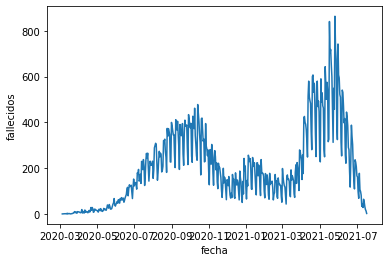

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.lineplot(x="fecha", y="fallecidos", data=dfTemp2.toPandas())
plt.show()


# levanto el dataset de migrantes

Voy a levantar ahora los dos archivos de migrantes, unirlos. Estos archivos corresponden a dos pedidos de información distintos.

In [18]:
schema_mig = (StructType()
          .add("id_caso", IntegerType())
          .add("nacionalidad", StringType())
          .add("pais_nacimiento", StringType())
          .add("tipo_doc", StringType())
          .add("nro_doc", IntegerType())
          .add("doc_argentino", IntegerType())
          .add("base", IntegerType())
         )

In [19]:
dfmig1 = (spark.read.option("delimiter", ";").csv("/dataset/covid/migrantes2020.csv", 
                         schema=schema_mig, header=True, 
                         ignoreLeadingWhiteSpace=True, 
                         ignoreTrailingWhiteSpace=True))


In [20]:
#dfmig1.show()

In [21]:
dfmig2 = (spark.read.option("delimiter", ";").csv("/dataset/covid/migrantes2021.csv", 
                         schema=schema_mig, header=True, 
                         ignoreLeadingWhiteSpace=True, 
                         ignoreTrailingWhiteSpace=True))

In [22]:
dfmig2.printSchema()

root
 |-- id_caso: integer (nullable = true)
 |-- nacionalidad: string (nullable = true)
 |-- pais_nacimiento: string (nullable = true)
 |-- tipo_doc: string (nullable = true)
 |-- nro_doc: integer (nullable = true)
 |-- doc_argentino: integer (nullable = true)
 |-- base: integer (nullable = true)



In [27]:
#uno ambas bases
dfmig=dfmig1.union(dfmig2)

In [28]:
dfmig.printSchema()

root
 |-- id_caso: integer (nullable = true)
 |-- nacionalidad: string (nullable = true)
 |-- pais_nacimiento: string (nullable = true)
 |-- tipo_doc: string (nullable = true)
 |-- nro_doc: integer (nullable = true)
 |-- doc_argentino: integer (nullable = true)
 |-- base: integer (nullable = true)



In [30]:
dfmig.count()

11437754

Hay un total de 11.437.754 registros.
Como se puede ver son menos que los casos originales.


In [32]:
#dfmig.count()
#analizo la distribución aprox de migrantes, luego se incorpora una variable más específica
dfmig.groupBy('pais_nacimiento').count().orderBy('count').show()

+-------------------+-----+
|    pais_nacimiento|count|
+-------------------+-----+
| Bosnia Herzegovina|    1|
|          Sri Lanka|    1|
|            Somalia|    1|
|    Costa de Marfil|    1|
|              Malta|    1|
|           Barbados|    1|
|          Antartida|    1|
|            Bahamas|    1|
|           Suriname|    1|
|             Zambia|    1|
|        Swazilandia|    1|
|         Mozambique|    1|
|            Grenada|    1|
|       Islas Caiman|    1|
|Antillas Holandesas|    1|
|               Mal�|    1|
|      Guinea Bissau|    1|
|            Jamaica|    1|
|            Eritrea|    1|
|       Azerbaidahan|    1|
+-------------------+-----+
only showing top 20 rows



## Cración de base casos + migrantes

Creo una unica base haciendo join con ambas bases: casos y migrantes. De la base de migrantes me quedo además solo con pais de nacimiento

NOTA: para un trabajo más específico hay que diferenciar entre migrantes y extranjeros. Para definir migrantes se puede tomar personas nacidas en un país distinto a Argentina pero que residen en Argentina. (https://www.academia.edu/44535050/Incidencia_del_COVID_en_la_poblaci%C3%B3n_migrante_en_Argentina)
En este trabajo se tomará directamente pais de nacimiento <> Argentina.

In [38]:
##
dfcasos.createOrReplaceTempView("dfcasos")
dfmig.createOrReplaceTempView("dfmig")

dfTemp2= spark.sql(""" SELECT id_evento_caso,sexo, edad,
fecha_inicio_sintomas,fecha_apertura,fecha_diagnostico,
sepi_apertura,origen_financiamiento,
residencia_provincia_id,residencia_departamento_id,
pais_nacimiento,
fecha_internacion,cuidado_intensivo,fallecido
FROM dfcasos join dfmig on dfcasos.id_evento_caso=dfmig.id_caso
     """)



In [39]:
#vuelvo a chequear la distribución de fallecido
dfTemp2.groupBy('fallecido').count().orderBy('count').show()

+---------+-------+
|fallecido|  count|
+---------+-------+
|       SI|  47811|
|       NO|1619624|
+---------+-------+



In [1]:
dfTemp2.count()

NameError: name 'dfTemp2' is not defined

Al hacer el join me quedo con un dataset que logré machear con ambas bases y que corresponde a casos confirmados.
Tengo un total de XXXXXXX casos

In [ ]:
#vuelvo a chequear la distribución de fallecido
#dfTemp2.groupBy('pais_nacimiento').count().orderBy('count').show()

Se guardan los archivos en formato parquet. Voy a probar si luego se mejora el performance.

In [42]:
dfTemp2.write.parquet("/dataset/parque-confirmados-completo/covid-completo.parquet") 